In [2]:
# ### Download and unzip hidden data set for leaderboard
# # Link to Public folder: https://drive.google.com/file/d/1nZ9JkV1EThO64vf9u6gTnuWDoKw2nF_m
# # Link to copy on group repo: https://drive.google.com/file/d/1WV5UZyXtmmG3qDkZsqjfT_PS0_16VD8U
# !gdown https://drive.google.com/uc?id=1WV5UZyXtmmG3qDkZsqjfT_PS0_16VD8U
# !unzip hidden_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: hidden/video_15052/image_5.png  
  inflating: __MACOSX/hidden/video_15052/._image_5.png  
  inflating: hidden/video_15052/image_7.png  
  inflating: __MACOSX/hidden/video_15052/._image_7.png  
  inflating: hidden/video_15052/image_6.png  
  inflating: __MACOSX/hidden/video_15052/._image_6.png  
  inflating: hidden/video_15294/image_10.png  
  inflating: __MACOSX/hidden/video_15294/._image_10.png  
  inflating: hidden/video_15294/image_8.png  
  inflating: __MACOSX/hidden/video_15294/._image_8.png  
  inflating: hidden/video_15294/image_9.png  
  inflating: __MACOSX/hidden/video_15294/._image_9.png  
  inflating: hidden/video_15294/image_2.png  
  inflating: __MACOSX/hidden/video_15294/._image_2.png  
  inflating: hidden/video_15294/image_3.png  
  inflating: __MACOSX/hidden/video_15294/._image_3.png  
  inflating: hidden/video_15294/image_1.png  
  inflating: __MACOSX/hidden/video_15294/._image_1.png  
  inflating: hidden/

In [19]:
# ## Download dataset for testing
# !gdown https://drive.google.com/uc?id=1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2
# !mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
# #https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
# !unzip Dataset_Student_annot.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_Student/val/data/video_1941/image_11.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_11.png  
  inflating: Dataset_Student/val/data/video_1941/image_8.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_8.png  
  inflating: Dataset_Student/val/data/video_1941/image_9.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_9.png  
  inflating: Dataset_Student/val/data/video_1941/mask.npy  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._mask.npy  
  inflating: Dataset_Student/val/data/video_1941/image_2.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_2.png  
  inflating: Dataset_Student/val/data/video_1941/image_3.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_3.png  
  inflating: Dataset_Student/val/data/video_1941/image_1.png  
  inflating: __MACOSX/Dataset_Student/val/data/video_1941/._image_1.

In [5]:
# ## Change dir structure
# !mv hidden/ data/
# !mkdir hidden/
# !mv data/ hidden/data/

In [1]:
import sys
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any

import time

import torch
import torch.nn as nn

import numpy as np
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import io
from ipywidgets import widgets, HBox
import torch.nn.functional as F
from torch.utils.data import Dataset
from einops import rearrange
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics

from argparse import ArgumentParser, Namespace

from dataset.video_dataset import VideoFrameDataset, ImglistToTensor, MaskDataset

from models.Seq2Seq import Seq2Seq
from models.UNet import UNet

In [2]:
hidden_path = '/scratch/ln2205/hidden' # path to hidden dataset, change it accordingly

Generate annotations for hidden dataset if they have not been generated yet. Otherwise, skip the next two cells.

In [3]:
def annotate(min_i,max_i,output_dir):
    with open(os.path.join(output_dir, 'annotations.txt'), 'w') as f:
        for i in range(min_i, max_i):
            f.write(f'video_{i} 0 10 0 \n') #should be 11 frames instead of 22


annotate(15000, 17000, hidden_path)

In [4]:
os.system(f"mkdir {os.path.join(hidden_path, 'data')}")
os.system(f"mv {os.path.join(hidden_path, 'video_*')} {os.path.join(hidden_path, 'data')}")

mkdir: cannot create directory ‘/scratch/ln2205/hidden/data’: File exists
mv: cannot stat '/scratch/ln2205/hidden/video_*': No such file or directory


256

In [5]:
## Set up dataloader for hidden dataset
def load_hidden_data(root, annotation_file, batch_size=1, mask=False, shuffle=False):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            transforms.Normalize((0.61749697, 0.6050092, 0.52180636), (2.1824553, 2.1553133, 1.9115673)),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=11,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=mask, # this needs to be false
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle, # important for this to be false
            num_workers=1,
            pin_memory=True
        )
    return dataloader

batch_size = 1
hiddenloader = load_hidden_data(os.path.join(hidden_path, 'data/'), os.path.join(hidden_path, 'annotations.txt'), batch_size, False, False)

In [6]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
best_unet_model_path = '/scratch/ln2205/best_model_UNet.pkl' # path to best UNet model, change it accordingly

In [8]:
## Load masker model from best checkpoint
UNet_masker = UNet(
    n_class=49,
)

### Load model:
unet_saved_data = torch.load(best_unet_model_path, map_location=device)
UNet_masker.load_state_dict(unet_saved_data)

<All keys matched successfully>

In [9]:
UNet_masker.to(device)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [10]:
best_LSTM_model_path = '/scratch/ln2205/best_model_LSTM.pkl' # path to best LSTM model, change it accordingly

In [11]:
## Load ConvLSTM model from best checkpoint
ConvLSTM_predictor = Seq2Seq(num_channels=49, num_kernels=64, kernel_size=(3, 3), 
                             padding=(1, 1), activation="relu", frame_size=(160, 240), 
                             num_layers=5, device=device)

### Load saved model:
ConvLSTM_saved_data = torch.load(best_LSTM_model_path, map_location=device)
ConvLSTM_predictor.load_state_dict(ConvLSTM_saved_data)
ConvLSTM_predictor.to(device)

Seq2Seq(
  (sequential): Sequential(
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(113, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm3): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convlstm4): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (batchnorm4): BatchNo

In [12]:
## Utils
def one_hot_encoding(input_tensor, num_classes=49):
    one_hot = F.one_hot(input_tensor.long(), num_classes)
    #print(one_hot.shape)
    one_hot = rearrange(one_hot, 'b f h w c -> b c f h w')  # Change the dimensions to (batch_size, num_classes, height, width)
    return one_hot

def collate(batch):

    batch = torch.cat(batch)

    # Add channel dim, scale pixels between 0 and 1, send to GPU

    #split input and target
    rand = np.random.randint(11,21)
    input = batch[:,rand-11:rand, :, :]
    target = batch[:,rand,:,:]
    input = one_hot_encoding(input, 49)             
    # input, target = input.to(device), target.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target                   
    return input, target 

def compute_jaccard(ground_truth_mask, predicted_mask):
  jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49) #.to(device)
  return jaccard(torch.Tensor(ground_truth_mask), torch.Tensor(predicted_mask))

In [13]:
val_path = "/val" # path to validation dataset, change it accordingly

In [15]:
from tqdm import tqdm

### Dataloader method
def load_data_unshuffled(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            # transforms.Resize((160,240)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize((0.61749697, 0.6050092, 0.52180636), (2.1824553, 2.1553133, 1.9115673)),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=True,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

valloader = load_data_unshuffled(os.path.join(val_path, 'data/'), os.path.join(val_path, 'annotations.txt'), batch_size=1)

In [16]:
## Define prediction loop
def generate_predictions_for_hidden(masker, predictor, hiddenloader, device):
  hidden_results = []

  masker.eval()
  predictor.eval()

  for i, data in enumerate(hiddenloader, 0):
    input, label = data
    input, label = input.to(device), label.to(device)

    context = torch.argmax(masker(input.squeeze(0)), dim=1)
    context = one_hot_encoding(context.unsqueeze(0), 49)

    for frame in range(11): # predict next 11 frames
      pred = predictor(context)
      pred = torch.argmax(pred, dim=1)
      if frame == 10:
        hidden_results.append(pred)
      pred = one_hot_encoding(pred.unsqueeze(1))
      context = context[:,:,-10:]
      context = torch.cat([context, pred], dim=2)
    
  results_hidden_tensor = torch.cat(hidden_results, dim=0)
  print(results_hidden_tensor.shape) # output should be 2000 x 160 x 240
  return results_hidden_tensor

In [17]:
results_hidden_tensor = generate_predictions_for_hidden(UNet_masker, ConvLSTM_predictor, hiddenloader, device)

KeyboardInterrupt: 

In [38]:
results_hidden_tensor.shape

torch.Size([2000, 160, 240])

In [39]:
torch.unique(results_hidden_tensor)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], device='cuda:0')

In [40]:
## Save all as tensor
torch.save(results_hidden_tensor, 'results_hidden_tensor.pt')

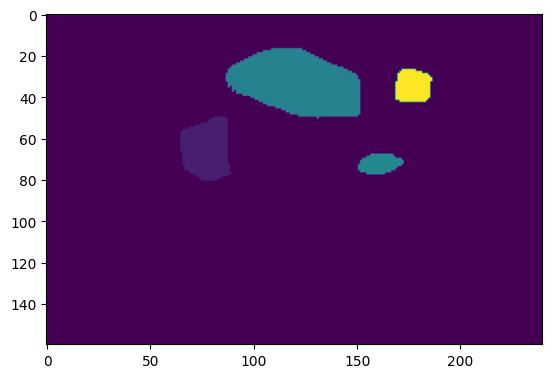

In [64]:
## Sense checking
plt.imshow(results_hidden_tensor[1].cpu().numpy())